<a href="https://colab.research.google.com/github/rbdus0715/Machine-Learning/blob/main/study/torch/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import pandas as pd
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [ ]:
random_seed = 42
batch_size = 512
epochs = 40
learning_rate = 1e-4
num_classes = 10
patch_size = 4
img_size = 28
in_channels = 1
num_heads = 8
dropout = 0.001
hidden_dim = 768
adam_weight_decay = 0
adam_betas = (0.9, 0.999)
activation = "gelu"
num_encoders = 4
embed_dim = (patch_size ** 2) * in_channels
num_patches = (img_size // patch_size) ** 2

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size
            ),
            nn.Flatten(2)
        )
        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.dropout(x)
        return x

model = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)

torch.Size([512, 50, 16])


In [ ]:
class ViT(nn.Module):
    def __init__(self,
                 num_patches,
                 num_classes,
                 patch_size,
                 embed_dim,
                 num_encoders,
                 num_heads,
                 hidden_dim,
                 dropout,
                 activation,
                 in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim,
                                               patch_size,
                                               num_patches,
                                               dropout,
                                               in_channels)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim,
                                                   nhead=num_heads,
                                                   dropout=dropout,
                                                   activation=activation,
                                                   batch_first=True,
                                                   norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :]) # cls token
        return x

model = ViT(num_patches,
            num_classes,
            patch_size,
            embed_dim,
            num_encoders,
            num_heads,
            hidden_dim,
            dropout,
            activation,
            in_channels).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([512, 10])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/datasets/kaggle.digit_recognition_mnist.data/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/datasets/kaggle.digit_recognition_mnist.data/test.csv")

In [ ]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=random_seed, shuffle=True)

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels, indicies, mode):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        if mode == "train":
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])
            ])
        elif mode == "valid":
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])
            ])
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image":image, "label":label, "index":index}

37800
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

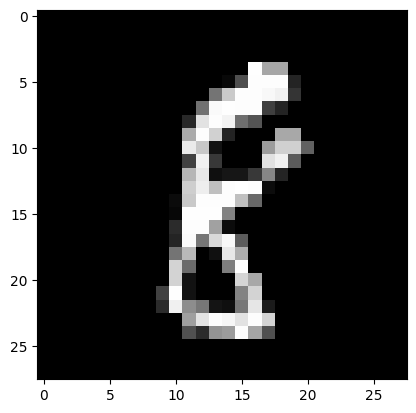

In [ ]:
plt.figure()
f, axarr = plt.subplots(1, 1)
train_dataset = MNISTDataset(train_df.iloc[:, 1:].values.astype(np.uint8),
                             train_df.iloc[:, 0].values,
                             train_df.index.values, mode="train")

valid_dataset = MNISTDataset(train_df.iloc[:, 1:].values.astype(np.uint8),
                             train_df.iloc[:, 0].values,
                             train_df.index.values, mode="valid")

print(len(train_dataset))
print(train_dataset[0])
axarr.imshow(train_dataset[0]["image"].squeeze(), cmap="gray")

In [ ]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True)

valid_dataloader = DataLoader(dataset=valid_dataset,
                              batch_size=batch_size,
                              shuffle=True)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),
                       betas=adam_betas,
                       lr=learning_rate,
                       weight_decay=adam_weight_decay)

start = timeit.default_timer()
for epoch in tqdm(range(epochs), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())

        loss = criterion(y_pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss = loss.item()
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(valid_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train loss epoch {epoch+1}: {train_loss:.4f}")
    print(f"Valid loss epoch {epoch+1}: {val_loss:.4f}")
    print(f"Train accuracy epoch {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x==y) / len(train_labels):.4f}")
    print(f"Valid accuracy epoch {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x==y) / len(val_labels):.4f}")
    print("-"*30)

stop = timeit.default_timer()
print(f"Training time: {stop - start:.2f}")

100%|██████████| 74/74 [00:07<00:00, 10.32it/s]


------------------------------
Train loss epoch 1: 0.0221
Valid loss epoch 1: 1.5123
Train accuracy epoch 1: 0.4164


  2%|▎         | 1/40 [00:29<19:25, 29.89s/it]

Valid accuracy epoch 1: 0.4829
------------------------------


100%|██████████| 74/74 [00:08<00:00,  8.78it/s]


------------------------------
Train loss epoch 2: 0.0221
Valid loss epoch 2: 1.4820
Train accuracy epoch 2: 0.4492


  5%|▌         | 2/40 [01:00<19:15, 30.42s/it]

Valid accuracy epoch 2: 0.4828
------------------------------


100%|██████████| 74/74 [00:07<00:00,  9.54it/s]


------------------------------
Train loss epoch 3: 0.0196
Valid loss epoch 3: 1.4343
Train accuracy epoch 3: 0.4656


  8%|▊         | 3/40 [01:30<18:40, 30.29s/it]

Valid accuracy epoch 3: 0.5089
------------------------------


100%|██████████| 74/74 [00:06<00:00, 11.00it/s]


------------------------------
Train loss epoch 4: 0.0198
Valid loss epoch 4: 1.3836
Train accuracy epoch 4: 0.4816


 10%|█         | 4/40 [02:00<18:00, 30.02s/it]

Valid accuracy epoch 4: 0.5210
------------------------------


100%|██████████| 74/74 [00:07<00:00,  9.88it/s]


------------------------------
Train loss epoch 5: 0.0197
Valid loss epoch 5: 1.3366
Train accuracy epoch 5: 0.4948


 12%|█▎        | 5/40 [02:30<17:37, 30.22s/it]

Valid accuracy epoch 5: 0.5485
------------------------------


100%|██████████| 74/74 [00:08<00:00,  8.76it/s]


------------------------------
Train loss epoch 6: 0.0174
Valid loss epoch 6: 1.2756
Train accuracy epoch 6: 0.5151


 15%|█▌        | 6/40 [03:09<18:44, 33.07s/it]

Valid accuracy epoch 6: 0.5810
------------------------------


100%|██████████| 74/74 [00:12<00:00,  5.70it/s]


------------------------------
Train loss epoch 7: 0.0181
Valid loss epoch 7: 1.2494
Train accuracy epoch 7: 0.5245


 18%|█▊        | 7/40 [03:45<18:45, 34.12s/it]

Valid accuracy epoch 7: 0.5844
------------------------------


100%|██████████| 74/74 [00:14<00:00,  5.18it/s]


------------------------------
Train loss epoch 8: 0.0177
Valid loss epoch 8: 1.2052
Train accuracy epoch 8: 0.5460


 20%|██        | 8/40 [04:30<20:02, 37.58s/it]

Valid accuracy epoch 8: 0.6061
------------------------------


100%|██████████| 74/74 [00:10<00:00,  7.33it/s]


------------------------------
Train loss epoch 9: 0.0174
Valid loss epoch 9: 1.1718
Train accuracy epoch 9: 0.5479


 22%|██▎       | 9/40 [05:11<19:56, 38.61s/it]

Valid accuracy epoch 9: 0.6151
------------------------------


100%|██████████| 74/74 [00:08<00:00,  8.98it/s]


------------------------------
Train loss epoch 10: 0.0173
Valid loss epoch 10: 1.1784
Train accuracy epoch 10: 0.5671


 25%|██▌       | 10/40 [05:49<19:06, 38.22s/it]

Valid accuracy epoch 10: 0.6077
------------------------------


100%|██████████| 74/74 [00:13<00:00,  5.44it/s]


------------------------------
Train loss epoch 11: 0.0167
Valid loss epoch 11: 1.1132
Train accuracy epoch 11: 0.5747


 28%|██▊       | 11/40 [06:33<19:27, 40.25s/it]

Valid accuracy epoch 11: 0.6407
------------------------------


100%|██████████| 74/74 [00:10<00:00,  7.40it/s]


------------------------------
Train loss epoch 12: 0.0178
Valid loss epoch 12: 1.1208
Train accuracy epoch 12: 0.5860


 30%|███       | 12/40 [07:09<18:08, 38.89s/it]

Valid accuracy epoch 12: 0.6276
------------------------------


100%|██████████| 74/74 [00:08<00:00,  8.59it/s]


------------------------------
Train loss epoch 13: 0.0156
Valid loss epoch 13: 1.0416
Train accuracy epoch 13: 0.5937


 32%|███▎      | 13/40 [07:44<16:54, 37.59s/it]

Valid accuracy epoch 13: 0.6656
------------------------------


100%|██████████| 74/74 [00:06<00:00, 11.01it/s]


------------------------------
Train loss epoch 14: 0.0167
Valid loss epoch 14: 1.0134
Train accuracy epoch 14: 0.5980


 35%|███▌      | 14/40 [08:14<15:15, 35.23s/it]

Valid accuracy epoch 14: 0.6717
------------------------------


100%|██████████| 74/74 [00:07<00:00, 10.29it/s]


------------------------------
Train loss epoch 15: 0.0156
Valid loss epoch 15: 0.9994
Train accuracy epoch 15: 0.6025


 38%|███▊      | 15/40 [08:43<13:59, 33.59s/it]

Valid accuracy epoch 15: 0.6766
------------------------------


100%|██████████| 74/74 [00:08<00:00,  8.79it/s]


------------------------------
Train loss epoch 16: 0.0147
Valid loss epoch 16: 0.9728
Train accuracy epoch 16: 0.6135


 40%|████      | 16/40 [09:14<13:07, 32.83s/it]

Valid accuracy epoch 16: 0.6914
------------------------------


100%|██████████| 74/74 [00:07<00:00,  9.39it/s]


------------------------------
Train loss epoch 17: 0.0152
Valid loss epoch 17: 1.0298
Train accuracy epoch 17: 0.6239


 42%|████▎     | 17/40 [09:44<12:12, 31.85s/it]

Valid accuracy epoch 17: 0.6578
------------------------------


100%|██████████| 74/74 [00:06<00:00, 10.71it/s]


------------------------------
Train loss epoch 18: 0.0149
Valid loss epoch 18: 0.9325
Train accuracy epoch 18: 0.6230


 45%|████▌     | 18/40 [10:13<11:22, 31.02s/it]

Valid accuracy epoch 18: 0.6976
------------------------------


100%|██████████| 74/74 [00:06<00:00, 11.12it/s]


------------------------------
Train loss epoch 19: 0.0141
Valid loss epoch 19: 1.0052
Train accuracy epoch 19: 0.6250


 48%|████▊     | 19/40 [10:42<10:40, 30.48s/it]

Valid accuracy epoch 19: 0.6616
------------------------------


100%|██████████| 74/74 [00:07<00:00, 10.10it/s]


------------------------------
Train loss epoch 20: 0.0139
Valid loss epoch 20: 0.9461
Train accuracy epoch 20: 0.6374


 50%|█████     | 20/40 [11:12<10:07, 30.37s/it]

Valid accuracy epoch 20: 0.6901
------------------------------


100%|██████████| 74/74 [00:07<00:00,  9.81it/s]


------------------------------
Train loss epoch 21: 0.0146
Valid loss epoch 21: 0.8835
Train accuracy epoch 21: 0.6372


 52%|█████▎    | 21/40 [11:41<09:29, 29.95s/it]

Valid accuracy epoch 21: 0.7152
------------------------------


100%|██████████| 74/74 [00:07<00:00,  9.75it/s]


------------------------------
Train loss epoch 22: 0.0129
Valid loss epoch 22: 0.8630
Train accuracy epoch 22: 0.6431


 55%|█████▌    | 22/40 [12:10<08:53, 29.65s/it]

Valid accuracy epoch 22: 0.7208
------------------------------


100%|██████████| 74/74 [00:06<00:00, 10.97it/s]


------------------------------
Train loss epoch 23: 0.0140
Valid loss epoch 23: 0.8909
Train accuracy epoch 23: 0.6490
Valid accuracy epoch 23: 0.7043
------------------------------


100%|██████████| 74/74 [00:06<00:00, 10.85it/s]


------------------------------
Train loss epoch 24: 0.0133
Valid loss epoch 24: 0.8297
Train accuracy epoch 24: 0.6524


 60%|██████    | 24/40 [13:08<07:48, 29.28s/it]

Valid accuracy epoch 24: 0.7315
------------------------------


100%|██████████| 74/74 [00:06<00:00, 10.79it/s]


------------------------------
Train loss epoch 25: 0.0136
Valid loss epoch 25: 0.8746
Train accuracy epoch 25: 0.6628


 62%|██████▎   | 25/40 [13:37<07:16, 29.12s/it]

Valid accuracy epoch 25: 0.7090
------------------------------


100%|██████████| 74/74 [00:07<00:00,  9.39it/s]


------------------------------
Train loss epoch 26: 0.0139
Valid loss epoch 26: 0.8424
Train accuracy epoch 26: 0.6533


 65%|██████▌   | 26/40 [14:06<06:49, 29.27s/it]

Valid accuracy epoch 26: 0.7223
------------------------------


100%|██████████| 74/74 [00:07<00:00,  9.78it/s]


------------------------------
Train loss epoch 27: 0.0139
Valid loss epoch 27: 0.8251
Train accuracy epoch 27: 0.6607


 68%|██████▊   | 27/40 [14:35<06:19, 29.19s/it]

Valid accuracy epoch 27: 0.7318
------------------------------


100%|██████████| 74/74 [00:07<00:00,  9.82it/s]


------------------------------
Train loss epoch 28: 0.0138
Valid loss epoch 28: 0.7909
Train accuracy epoch 28: 0.6636


 70%|███████   | 28/40 [15:05<05:49, 29.14s/it]

Valid accuracy epoch 28: 0.7432
------------------------------


100%|██████████| 74/74 [00:06<00:00, 11.51it/s]


------------------------------
Train loss epoch 29: 0.0132
Valid loss epoch 29: 0.8482
Train accuracy epoch 29: 0.6689
Valid accuracy epoch 29: 0.7171
------------------------------


100%|██████████| 74/74 [00:06<00:00, 10.99it/s]


------------------------------
Train loss epoch 30: 0.0134
Valid loss epoch 30: 0.8125
Train accuracy epoch 30: 0.6678


 75%|███████▌  | 30/40 [16:02<04:49, 28.92s/it]

Valid accuracy epoch 30: 0.7346
------------------------------


100%|██████████| 74/74 [00:06<00:00, 10.99it/s]


------------------------------
Train loss epoch 31: 0.0122
Valid loss epoch 31: 0.7948
Train accuracy epoch 31: 0.6700


 78%|███████▊  | 31/40 [16:31<04:20, 28.91s/it]

Valid accuracy epoch 31: 0.7365
------------------------------


100%|██████████| 74/74 [00:07<00:00,  9.47it/s]


------------------------------
Train loss epoch 32: 0.0122
Valid loss epoch 32: 0.8311
Train accuracy epoch 32: 0.6731


 80%|████████  | 32/40 [17:00<03:52, 29.04s/it]

Valid accuracy epoch 32: 0.7208
------------------------------


100%|██████████| 74/74 [00:07<00:00,  9.47it/s]


------------------------------
Train loss epoch 33: 0.0132
Valid loss epoch 33: 0.8072
Train accuracy epoch 33: 0.6779
Valid accuracy epoch 33: 0.7307
------------------------------


100%|██████████| 74/74 [00:07<00:00,  9.71it/s]


------------------------------
Train loss epoch 34: 0.0118
Valid loss epoch 34: 0.7749
Train accuracy epoch 34: 0.6793
Valid accuracy epoch 34: 0.7438
------------------------------


100%|██████████| 74/74 [00:06<00:00, 10.89it/s]


------------------------------
Train loss epoch 35: 0.0125
Valid loss epoch 35: 0.7827
Train accuracy epoch 35: 0.6838


 88%|████████▊ | 35/40 [18:26<02:24, 28.85s/it]

Valid accuracy epoch 35: 0.7441
------------------------------


100%|██████████| 74/74 [00:06<00:00, 11.19it/s]


------------------------------
Train loss epoch 36: 0.0117
Valid loss epoch 36: 0.7460
Train accuracy epoch 36: 0.6810


 90%|█████████ | 36/40 [18:55<01:55, 28.83s/it]

Valid accuracy epoch 36: 0.7558
------------------------------


100%|██████████| 74/74 [00:07<00:00, 10.42it/s]


------------------------------
Train loss epoch 37: 0.0124
Valid loss epoch 37: 0.7440
Train accuracy epoch 37: 0.6862


 92%|█████████▎| 37/40 [19:25<01:27, 29.06s/it]

Valid accuracy epoch 37: 0.7529
------------------------------


100%|██████████| 74/74 [00:07<00:00,  9.44it/s]


------------------------------
Train loss epoch 38: 0.0110
Valid loss epoch 38: 0.7640
Train accuracy epoch 38: 0.6898
Valid accuracy epoch 38: 0.7448
------------------------------


100%|██████████| 74/74 [00:07<00:00,  9.45it/s]


------------------------------
Train loss epoch 39: 0.0115
Valid loss epoch 39: 0.7246
Train accuracy epoch 39: 0.6936


 98%|█████████▊| 39/40 [20:23<00:29, 29.18s/it]

Valid accuracy epoch 39: 0.7602
------------------------------


100%|██████████| 74/74 [00:07<00:00,  9.87it/s]


------------------------------
Train loss epoch 40: 0.0121
Valid loss epoch 40: 0.7475
Train accuracy epoch 40: 0.6886


100%|██████████| 40/40 [20:52<00:00, 31.32s/it]

Valid accuracy epoch 40: 0.7472
------------------------------
Training time: 1252.74


In [ ]:
torch.cuda.empty_cache()

In [ ]:
labels = []
ids = []
imgs = []
model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(valid_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i)+1 for i in sample["index"]])

        outputs = model(img)

        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

100%|██████████| 74/74 [00:08<00:00,  8.39it/s]


<Figure size 640x480 with 0 Axes>

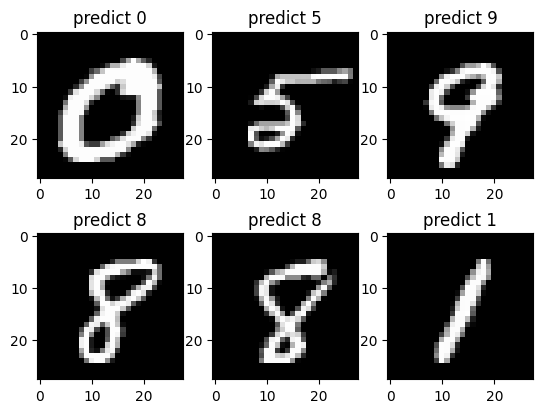

In [ ]:
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"predict {labels[counter]}")
        counter += 1

plt.show()